# <div style="color:#ffffff; border-radius:60px; border:#000000 solid; padding: 15px; background-color: #3c6478; font-size:100%; text-align:center; font-family:monospace;">Loading the data set</div>

In [3]:
import pandas as pd

In [4]:
train = pd.read_csv("twitter_training.csv")
val = pd.read_csv("twitter_validation.csv")

In [5]:
train = train.iloc[:, 2:]
train.columns = ['label', 'data']
val = val.iloc[:, 2:]
val.columns = ['label', 'data']

In [6]:
train.head()

,label,data
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [7]:
train.label.unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [8]:
train.isna().sum()

label      0
data     686
dtype: int64

In [9]:
train = train.dropna()

In [10]:
train.label.unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

<Axes: xlabel='label'>

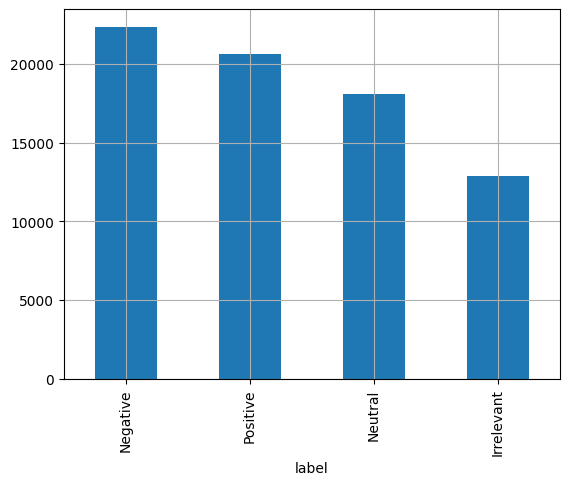

In [11]:
train.label.value_counts().plot(kind = 'bar', grid = True)

<Axes: xlabel='label'>

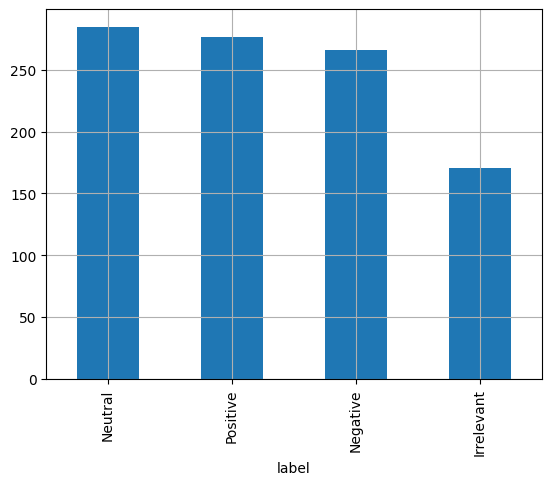

In [12]:
val.label.value_counts().plot(kind = 'bar', grid = True)

In [13]:
y = train["label"]
X = train["data"]
y_val = val["label"]
X_val = val["data"]

# <div style="color:#ffffff; border-radius:60px; border:#000000 solid; padding: 15px; background-color: #3c6478; font-size:100%; text-align:center; font-family:monospace;">Data Pre processing</div>

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# X = [str(x) for x in X]

# Tokenization
tokenizer = Tokenizer(num_words=10000)  
tokenizer.fit_on_texts(X)
tokenizer.fit_on_texts(X_val)

X = tokenizer.texts_to_sequences(X)
X_val = tokenizer.texts_to_sequences(X_val)


# Padding
max_len = 100  # Define the maximum sequence length
X = pad_sequences(X, maxlen=max_len,padding="post")
X_val = pad_sequences(X_val, maxlen=max_len,padding="post")

# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=4)
y_val = label_encoder.transform(y_val)
y_val = to_categorical(y_val, num_classes=4)

In [15]:
X[1].shape

(100,)

In [16]:
print(X.shape)
print(y.shape)
print(X_val.shape)
print(y_val.shape)

(73995, 100)
(73995, 4)
(999, 100)
(999, 4)


# <div style="color:#ffffff; border-radius:60px; border:#000000 solid; padding: 15px; background-color: #3c6478; font-size:100%; text-align:center; font-family:monospace;">Model Architecture</div>

In [17]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Define the model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))

# Bidirectional LSTM layers
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))

# Dropout for regularization
model.add(Dropout(0.5))

# BatchNormalization for stabilizing training
model.add(BatchNormalization())

# Dense layer with softmax activation for classification
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

model.summary()


C:\Users\thens\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(X, y, epochs=20, batch_size=128, validation_data=(X_val, y_val), callbacks=[reduce_lr])

Epoch 1/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 209s 352ms/step - accuracy: 0.5160 - loss: 1.1077 - val_accuracy: 0.8378 - val_loss: 0.4691 - learning_rate: 0.0010
Epoch 2/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 196s 338ms/step - accuracy: 0.7829 - loss: 0.5780 - val_accuracy: 0.9129 - val_loss: 0.2467 - learning_rate: 0.0010
Epoch 3/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 224s 387ms/step - accuracy: 0.8388 - loss: 0.4364 - val_accuracy: 0.9359 - val_loss: 0.1875 - learning_rate: 0.0010
Epoch 4/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 241s 416ms/step - accuracy: 0.8684 - loss: 0.3556 - val_accuracy: 0.9409 - val_loss: 0.1733 - learning_rate: 0.0010
Epoch 5/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 251s 433ms/step - accuracy: 0.8854 - loss: 0.3075 - val_accuracy: 0.9550 - val_loss: 0.1542 - learning_rate: 0.0010
Epoch 6/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 245s 424ms/step - accuracy: 0.9004 - loss: 0.2741 - val_accuracy: 0.9520 - val_loss: 0.1599 - learning_rate: 0.0010
Epoch 7/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 231s 399ms/step - accura

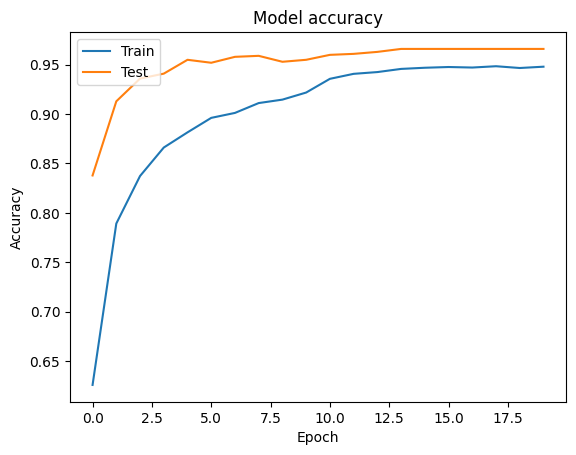

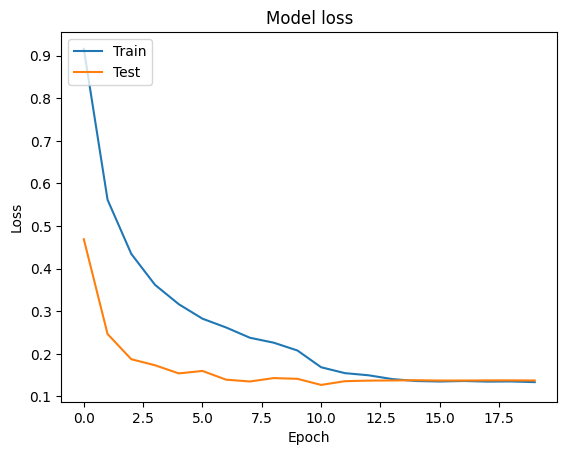

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [20]:
model.save("sentiment_analysis_model.h5")

In [21]:
import numpy as np
for i in range(12):
    input_sequence = X[i].reshape(1, -1)
    print("---------------------------------")
    print(np.argmax(y[i]))
    print(np.argmax(model.predict(input_sequence, verbose=0)))

---------------------------------
3
3
---------------------------------
3
3
---------------------------------
3
3
---------------------------------
3
3
---------------------------------
3
3
---------------------------------
3
3
---------------------------------
3
3
---------------------------------
3
3
---------------------------------
3
3
---------------------------------
3
3
---------------------------------
3
2
---------------------------------
2
2


In [29]:
from keras.models import load_model

# Load the saved model
model = load_model("sentiment_analysis_model.h5")

# Preprocess your input text
input_text = "Sudharsan is a Gay"
input_sequence = tokenizer.texts_to_sequences([input_text])
input_sequence = pad_sequences(input_sequence, maxlen=max_len, padding="post")

# Make predictions
predictions = model.predict(input_sequence)

# Convert predictions to sentiment labels
sentiment_labels = ['Negative', 'Neutral', 'Positive', 'Mixed']
predicted_sentiment = sentiment_labels[np.argmax(predictions)]

print("Predicted Sentiment:", predicted_sentiment)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
Predicted Sentiment: Mixed
